In [1]:
import pandas as pd
import cobra
# analysis_df = pd.read_json('./Data/flanalysis_BM_SG1.json').set_index('Gene_inhibition')
# analysis_DG_df = pd.read_json('./Data/flanalysis_BM_DG1.json').set_index('Gene_inhibition')
# E0 = cobra.io.read_sbml_model("./models/iML1515_E0.xml")

In [2]:
Biomass_df = pd.read_csv('./Data/BM_SG1.csv').set_index('cycle')
# Biomass_df

In [4]:
log_step=5
def get_cycle_maxgr(df):
    return df.iloc[-1]/2
    
def find_upneighbour(df):
    values = get_cycle_maxgr(df)
    position = list()
    
    def correct_cycle(cycle):
        mod = cycle%log_step
        return cycle if mod==0 else cycle+log_step-mod
    
    for i, value in enumerate(values):
        df_search = df.iloc[:,i]
        upperneighbour_ind = df_search[df_search >= value].idxmin()
        position.append(upperneighbour_ind)
        cycle = [df.index[pos] for pos in position]
        cycle = [correct_cycle(cy) for cy in cycle]
    return cycle

desired_BM = Biomass_df.filter(regex="Normal_coculture")
desired_cycle = find_upneighbour(desired_BM)

In [125]:
alpha_table = pd.read_csv('./Data/alpha_table.csv', index_col='Gene_inhibition')

In [6]:
genes = 'folA'

In [7]:
def get_gene_id(model, gene_name):
    for i in model.genes:
        if(i.name == gene_name):
            return(i.id)

def convert_arg_to_list(arg):
    if type(arg) is not list and type(arg) is not tuple:
        arg = [arg]
    return(arg)

In [8]:
# query alpha, combine back ~
"""
add S0
!! 2 genes coding for same reaciton not yet included
? only need sort by alpha?
? query alpha table  -> list of alphas
"""

def adjust_flux_df(df):
    if genes != 'Normal':
        v1_cols = df.filter(regex='v1').columns
        for gene in convert_arg_to_list(genes):
            rcts = list()
            for rct in E0.genes.get_by_id(get_gene_id(E0, genes)).reactions:
                rcts.append(rct.id)

            for v1_col in (set(v1_cols) and set(rcts)): # associated with gene/ find from gene
                original_col = v1_col.replace("_v1", '')
                df[f'{original_col}'] = df[f'{original_col}'] + df[f'{v1_col}']/alpha_table.loc[f'{gene}', 'E0']
                df.drop(v1_col)
                v1_cols.drop(f'{v1_col}')
    return None

In [62]:
def remove_Zero_col(df): # extend N differ than 0 
    return(df.loc[:, (df !=0).any(axis=0)]) 

def adjust_flux_df(df, genes):
    if genes != 'Normal':
        v1_cols = df.filter(regex='v1').columns
        orig_cols = [ele.replace("_v1", '') for ele in df.filter(regex='v1').columns]
        for gene in convert_arg_to_list(genes):
            rcts = list()
            for rct in E0.genes.get_by_id(get_gene_id(E0, genes)).reactions:
                rcts.append(rct.id)

            for original_col in (set(orig_cols) & set(rcts)): # associated with gene/ find from gene
                v1_col = original_col + "_v1"
                df[f'{original_col}'] = df[f'{original_col}'] + df[f'{v1_col}']/alpha_table.loc[f'{gene}', 'E0']
                df = df.drop(f'{v1_col}', axis=1)
                v1_cols.drop(f'{v1_col}')
#     print(df.filter(regex='v1').columns)
    return df

def get_desired_BM(Biomass_df = Biomass_df, regex='Normal_coculture'):
    return Biomass_df.filter(regex=regex)

def get_row_grmax(desired_BM, genes='Normal'): # currently only E0
    desired_cycle = find_upneighbour(desired_BM)
    dfE = analysis_df.loc[genes, 'E0_coculture_flux']
#     dfE = remove_Zero_col(pd.read_json(dfE). # no use 
    dfE = (pd.read_json(dfE). 
           query("cycle in @desired_cycle").
           drop(['x','y','cycle'], axis=1))
    dfE.index = [genes]
    
    return dfE

def get_genes_compare(gene_list, Biomass_df, regex): # generate every gene-> subset
    desired_BM = get_desired_BM(Biomass_df, regex=regex)
    compare_list = list()
    for genes in gene_list:

        temp_df = get_row_grmax(desired_BM, genes=genes) # for flux only
        """
        If ~ == flux/ not metabo
        """    
        temp_df = adjust_flux_df(temp_df, genes)
        compare_list.append(temp_df)
        
    compare_df = (remove_Zero_col(pd.concat(compare_list)).T. # row to column
                  sort_values(by='Normal', key=abs, ascending=False)) # with 0 cell
    
#     compare_df = (pd.concat([
#         get_row_grmax(desired_BM, genes=genes) for genes in gene_list]).
#                   T. # row to column
#                   sort_values(by='Normal', key=abs, ascending=False)) # with 0 cell
    return compare_df
# Independent Extra sorted??? 
# order by flux ordering in Esher


compare_df = get_genes_compare(['folA', 'folP','Normal'], Biomass_df, 'Normal_coculture')

In [67]:
# compare_df = compare_df.rename_axis('Reactions').reset_index()
def get_abs_df(df):
    return (pd.DataFrame({colname: abs(col) for colname, col in df.items()}).
                  rename_axis('Reactions').
                  reset_index())


compare_abs_df = get_abs_df(compare_df)

In [64]:
# create base layer for Normal 
Normal_df = compare_abs_df[['Normal', 'Reactions']]

In [65]:
compare_df_long = compare_df.drop('Normal', axis=1).melt(ignore_index=False, 
                             var_name='Genes')

In [66]:
compare_df_long

,Genes,value
ATPS4rpp,folA,7.488875e+00
CYTBO3_4pp,folA,4.687602e+00
NADH16pp,folA,3.929040e+00
H2Otpp,folA,-3.251874e+00
EX_h2o_e,folA,2.940251e+00
...,...,...
NADTRHD,folP,5.838282e-01
RPE,folP,-5.589000e-07
GLYCLTt4pp,folP,0.000000e+00
ASPO3,folP,0.000000e+00


In [ ]:
key = ('dadX.rffG',
'dadX.pyrD',
'dadX.guaB')
v = 

In [165]:
analysis_df.head()

,coculture_media,E0_coculture_flux,S0_ac_coculture_flux,E0_monoculture_media,E0_monoculture_flux,S0_ac_monoculture_media,S0_ac_monoculture_flux
Gene_inhibition,,,,,,,
dadX.aroA,"{""metabolite"":{""0"":""ca2_e"",""1"":""cl_e"",""2"":""cob...","{""cycle"":{""0"":5,""2"":10,""4"":15,""6"":20,""8"":25,""1...","{""cycle"":{""1"":5,""3"":10,""5"":15,""7"":20,""9"":25,""1...","{""metabolite"":{""0"":""ca2_e"",""1"":""cl_e"",""2"":""cob...","{""cycle"":{""0"":5,""1"":10,""2"":15,""3"":20,""4"":25,""5...","{""metabolite"":{""0"":""ac_e"",""1"":""ca2_e"",""2"":""cl_...","{""cycle"":{""0"":5,""1"":10,""2"":15,""3"":20,""4"":25,""5..."
dadX.eno,"{""metabolite"":{""0"":""ca2_e"",""1"":""cl_e"",""2"":""cob...","{""cycle"":{""0"":5,""2"":10,""4"":15,""6"":20,""8"":25,""1...","{""cycle"":{""1"":5,""3"":10,""5"":15,""7"":20,""9"":25,""1...","{""metabolite"":{""0"":""ca2_e"",""1"":""cl_e"",""2"":""cob...","{""cycle"":{""0"":5,""1"":10,""2"":15,""3"":20,""4"":25,""5...","{""metabolite"":{""0"":""ac_e"",""1"":""ca2_e"",""2"":""cl_...","{""cycle"":{""0"":5,""1"":10,""2"":15,""3"":20,""4"":25,""5..."
dadX.pheA,"{""metabolite"":{""0"":""ca2_e"",""1"":""cl_e"",""2"":""cob...","{""cycle"":{""0"":5,""2"":10,""4"":15,""6"":20,""8"":25,""1...","{""cycle"":{""1"":5,""3"":10,""5"":15,""7"":20,""9"":25,""1...","{""metabolite"":{""0"":""ca2_e"",""1"":""cl_e"",""2"":""cob...","{""cycle"":{""0"":5,""1"":10,""2"":15,""3"":20,""4"":25,""5...","{""metabolite"":{""0"":""ac_e"",""1"":""ca2_e"",""2"":""cl_...","{""cycle"":{""0"":5,""1"":10,""2"":15,""3"":20,""4"":25,""5..."
dadX.acnB,"{""metabolite"":{""0"":""ca2_e"",""1"":""cl_e"",""2"":""cob...","{""cycle"":{""0"":5,""2"":10,""4"":15,""6"":20,""8"":25,""1...","{""cycle"":{""1"":5,""3"":10,""5"":15,""7"":20,""9"":25,""1...","{""metabolite"":{""0"":""ca2_e"",""1"":""cl_e"",""2"":""cob...","{""cycle"":{""0"":5,""1"":10,""2"":15,""3"":20,""4"":25,""5...","{""metabolite"":{""0"":""ac_e"",""1"":""ca2_e"",""2"":""cl_...","{""cycle"":{""0"":5,""1"":10,""2"":15,""3"":20,""4"":25,""5..."
aroA.dapF,"{""metabolite"":{""0"":""ca2_e"",""1"":""cl_e"",""2"":""cob...","{""cycle"":{""0"":5,""2"":10,""4"":15,""6"":20,""8"":25,""1...","{""cycle"":{""1"":5,""3"":10,""5"":15,""7"":20,""9"":25,""1...","{""metabolite"":{""0"":""ca2_e"",""1"":""cl_e"",""2"":""cob...","{""cycle"":{""0"":5,""1"":10,""2"":15,""3"":20,""4"":25,""5...","{""metabolite"":{""0"":""ac_e"",""1"":""ca2_e"",""2"":""cl_...","{""cycle"":{""0"":5,""1"":10,""2"":15,""3"":20,""4"":25,""5..."


In [ ]:
json.loads('./Data/Ori_DG.json',object_pairs_hook=pairs)  


In [166]:
data = '{"foo": "bar", "foo": "baz"}'
json.loads(data, object_hook=)

TypeError: 'str' object is not callable

In [176]:
j='''{ "hosts":  {
             "example1.lab.com" : ["mysql", "apache"],
             "example2.lab.com" : ["sqlite", "nmap"],
             "example3.lab.com" : ["vim", "bind9"]
             }
}'''
specific_keys='example2'

specific_keys='example2'

found=False

def explore_js(js_object, index_keys, col_key): # index key-drug inhibition & col_key-culture column
    found_list=dict()
    specific_keys = index_keys if index_keys is not None else col_key # find this key
    for key,di in json.loads(js_object).items():    # items on Py 3k
        for k,v in di.items():
#             if k.startswith(index_keys):
            if k in specific_keys:
                # unpack to dataframe-> for outer layer

                found_list.update({k : explore_js(v, None, col_key)}) # search for col value
                specific_keys.drop(k)
                
                if not specific_keys:
                    found=True
                    break
        if found:
            break 
    
    return found_list # base case

In [180]:

def explore_js(js_object, index_keys, col_key): # index key-drug inhibition & col_key-culture column
    found_dict=dict()
    for key,di in json.loads(js_object).items():    # items on Py 3k
        if key in index_keys:
            for k,v in di.items():
    #             if k.startswith(index_keys):
                if k in col_key:
                    # unpack to dataframe-> for outer layer

                    found_dict.update({key: {k : v}}) # search for col value
                    col_key.drop(k)

                    if not col_key: 
                        break
        if not index_keys:
            break 
    
    return found_dict # base case

In [178]:
index_keys=['dadX.rffG']
col_key = 'E0_coculture_flux'

In [188]:
with open('./Data/Ori_DG.json') as json_data:
    for line in json_data:
        json.loads(line)
#         print(key)

In [204]:
pd.read_json(j)

,hosts
example1.lab.com,"[mysql, apache]"
example2.lab.com,"[sqlite, nmap]"
example3.lab.com,"[vim, bind9]"


In [231]:
pd.read_json(j, orient='index').to_json('j.json', orient='index')
pd.read_json('j.json')

,hosts
example1.lab.com,"[mysql, apache]"
example2.lab.com,"[sqlite, nmap]"
example3.lab.com,"[vim, bind9]"


In [225]:
type({})

dict

In [236]:
sup = supply_line('j.json')
for k in sup:
    a=k
#     key, val, v = k
#     print(pd.DataFrame(k))
#     print(vars(k))

In [253]:
a.get('k') is None


True

In [234]:
analysis_df.to_json('./Data/ccol_DG.json')

In [257]:
# try item
def retrive_specific_keys(file_name, culture_key, genes_dict):
    def supply_line(file_name):
#     file_name = f'./Data/{file_name}'
        with open(file_name) as fh:
            for line in fh:
                yield json.loads(line)

    supp = supply_line(f'{file_name}')
    for line in supp:    # culture as column
        genes_dict = line.get(f'{culture_key}')
        if not genes_dict:
            genes_dict = {current_gene: genes_dict.get(f'{current_gene}') for current_gene in genes_dict}  #subset of gene
    return {culture_key: genes_dict} # pd.read_json() culture_key -> col pd.read_json()

In [258]:
genes_culture_dict = retrive_specific_keys('./Data/ccol_DG.json', 'E0_coculture_flux', ['dadX.rffG'])


In [ ]:
gene

In [ ]:
def unpack_specific_keys(*args):
    genes_culture_dict = retrive_specific_keys(args)
    

In [193]:
with open('./Data/Ori_SG.json') as json_data:
#     for line in json_data:
    iterator_over_lines = map(json.loads, json_data)
    # just as you would do with a list but here the file is streamed
    for jsonline in iterator_over_lines:
        for key,di in jsonline:    # items on Py 3k
            print(key)

ValueError: too many values to unpack (expected 2)

In [182]:
# proceed
found_dict=dict()

with open('./Data/Ori_DG.json') as json_data:
    for line in json_data:
        
    for key,di in json.loads('./Data/Ori_DG.json').items():    # items on Py 3k
        if key in index_keys:
            for k,v in di.items():
    #             if k.startswith(index_keys):
                if k in col_key:
                    # unpack to dataframe-> for outer layer

                    found_dict.update({key: {k : v}}) # search for col value
                    col_key.drop(k)

                    if not col_key: 
                        break
        if not index_keys:
            break 

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [181]:
a = explore_js('./Data/flanalysis_BM_DG1.json', index_keys, col_key)

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [ ]:
json.loads('./Data/flanalysis_BM_DG1.json',object_pairs_hook=pairs)  

json.loads(j,object_pairs_hook=pairs)  

analysis_df = pd.read_json().set_index('Gene_inhibition')


In [127]:
analysis_df.to_json("./Data/Ori_SG.json", orient='index')

In [129]:
analysis_df = pd.read_json("./Data/Ori_SG.json", orient='index')

In [136]:
analysis_df.columns

Index(['coculture_media', 'E0_coculture_flux', 'S0_ac_coculture_flux',
       'E0_monoculture_media', 'E0_monoculture_flux',
       'S0_ac_monoculture_media', 'S0_ac_monoculture_flux'],
      dtype='object')

In [141]:
analysis_df = analysis_df.reset_index()
# set_index('Gene_inhibition')
# .to_json("./Data/Ori_DG.json", orient='index')

In [151]:
gene_inhibition = ['.'.join(map(str, l)) for l in analysis_df.Gene_inhibition]

analysis_df.Gene_inhibition =  ['.'.join(map(str, l)) for l in analysis_df.Gene_inhibition]

analysis_df = analysis_df.set_index('Gene_inhibition')

In [131]:
analysis_df = pd.read_json("./Data/flanalysis_BM_DG1.json")


In [ ]:
analysis_df.loc[genes, 'E0_coculture_flux']
analysis_df = pd.read_json('./Data/flanalysis_BM_SG1.json').set_index('Gene_inhibition')



In [82]:
def get_Normal_sorted_factor(after_sort_df):
    cat_df = (after_sort_df.
              reset_index(). # 1-n Index as index col
              assign(Reactions = lambda x: 
                     pd.Categorical(x.Reactions, categories=x.Reactions, ordered = True)))
    return(cat_df[['Normal', 'Reactions']], cat_df.drop(['Normal','index'], axis=1))

# get_compare_df_long(compare_df)

In [86]:
def get_plot_dfs(compare_df):
    normal_df, genes_df = get_Normal_sorted_factor(
        get_abs_df(compare_df))
    genes_df = genes_df.set_index('Reactions').melt(ignore_index=False,
            var_name='Genes').reset_index()
    return normal_df, genes_df

In [87]:
normal_df, genes_df = get_plot_dfs(compare_df)

In [97]:
compare_df

,folA,folP,Normal
ATPS4rpp,7.488875,5.692362e+00,16.412796
CYTBO3_4pp,4.687602,3.502993e+00,10.360123
NADH16pp,3.929040,2.919161e+00,8.788958
H2Otpp,-3.251874,-1.751507e+00,-8.764198
EX_h2o_e,2.940251,1.459593e+00,7.992006
...,...,...,...
NADTRHD,0.431529,5.838282e-01,0.000000
RPE,-0.023834,-5.589000e-07,0.000000
GLYCLTt4pp,0.000083,0.000000e+00,0.000000
ASPO3,0.017759,0.000000e+00,0.000000


In [98]:
normal_df1, genes_df1 = get_plot_dfs(compare_df.iloc[:30,])

In [50]:
df.Normal = df.Normal.abs()
df.folA = df.folA.abs()

In [161]:
from plotnine import ggplot, geom_area, aes
base = ggplot(df.iloc[:30,], aes(x='Reactions', y='Normal',group=1))+geom_area(fill = 'grey',alpha=0.5)


In [53]:
from plotnine.ggplot import *

In [94]:
# p = (ggplot(genes_df, aes(x='Reactions', y='Genes',group=1))+
#      geom_area()+
#      facet_wrap('Genes'))

In [104]:
p = (ggplot(genes_df1, aes(x='Reactions', y='value'))+
     geom_area()+
     facet_wrap('Genes'))

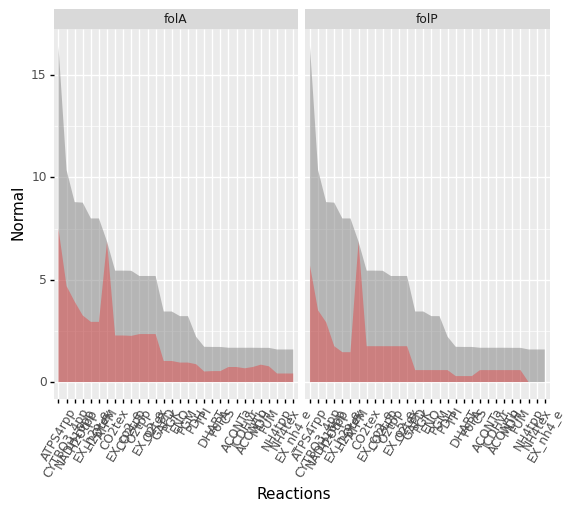

<ggplot: (-9223371927122688532)>

In [164]:
(base+
     geom_area(mapping=aes(x='Reactions', y='value',group=1), data=genes_df1,
               fill='red', alpha = 0.3, show_legend= True)+
     facet_wrap('Genes')+
     theme(axis_text_x=element_text(angle=60)
))

In [117]:
(ggplot(genes_df1, aes(x='Reactions', y='value',group=1))+
     geom_area(fill='red')+
     facet_wrap('Genes')+
     theme(axis_text_x=element_text(angle=60)))

AttributeError: 'ggplot' object has no attribute '__radd__'

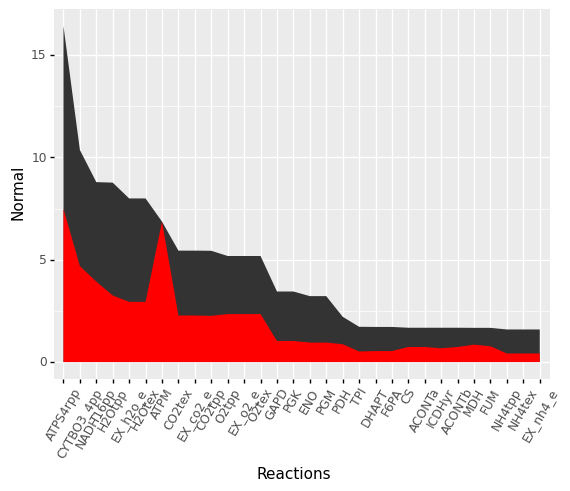

<ggplot: (-9223371927121825492)>

In [58]:
(base+ geom_area(aes(x='Reactions', y='folA'), fill='red') + 
    theme(axis_text_x=element_text(angle=60)))　
 

In [56]:
from plotnine import *

In [ ]:

compare_df_long = compare_df_long.rename_axis('Reactions').reset_index()


In [60]:
# compare_df_long = compare_df_long.rename_axis('Reactions').reset_index()
compare_df_long.value = compare_df_long.value.abs()

In [ ]:
compare_df_long.columns

In [ ]:
import seaborn as sns
g = sns.FacetGrid(compare_df_long, col='Genes')
g.map(sns.lineplot,'Reactions', 'value')

In [ ]:
Normal_df = compare_abs_df[['Normal']]

Normal_df = Normal_df.rename_axis('Reactions').reset_index()

In [ ]:
from plotnine import *
ggplot(survs_df, aes(x='weight', y='hindfoot_length')) + geom_point()



In [ ]:
# n=50
compare_df_long = compare_df.melt(ignore_index=False, var_name='Genes')
compare_df_long = compare_df_long.rename_axis('Flux').reset_index()
compare_df_long.value = compare_df_long.value.abs()

In [ ]:
so.Plot(compare_df_long, 'Flux', 'value', color = 'Genes').add(so.Area(alpha=.5))


In [ ]:
import seaborn.objects as so
so.Plot(compare_df_long, 'Flux', 'value', color = 'Genes').add(so.Area(alpha=.5))


In [ ]:
Normal_df

In [ ]:
so.Plot(Normal_df, 'Reactions', 'Normal').add(so.Area(alpha=.5))


In [ ]:
compare_abs_df

In [ ]:
plt.fill_between(compare_abs_df.Reactions, compare_abs_df.Normal)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
# Plot lines
ax.plot(time, income, color="green")
ax.plot(time, expenses, color="red")

# Fill area when income > expenses with green
ax.fill_between(
    time, income, expenses, where=(income > expenses), 
    interpolate=True, color="green", alpha=0.25, 
    label="Positive"
)

# Fill area when income <= expenses with red
ax.fill_between(
    time, income, expenses, where=(income <= expenses), 
    interpolate=True, color="red", alpha=0.25,
    label="Negative")

In [ ]:
import matplotlib.pyplot as plt
plt.fill_between(compare_abs_df.Reactions, compare_abs_df.folA)

In [ ]:
geom_area(aes(x='Reactions', y='Normal'))

In [ ]:
compare_abs_df['Normal'].plot()

In [ ]:
compare_abs_df = (pd.DataFrame({colname: abs(col) for colname, col in compare_df.items()}).
                  rename_axis('Reactions').
                  reset_index())

In [ ]:
ggplot(Normal_df, aes(x='Reactions', y='Normal',group=1))+geom_path()

In [ ]:
ggplot(compare_abs_df, aes(x='Reactions', y='Normal',group=1))+geom_line()

In [ ]:
# get_row_grmax(desired_BM, genes=genes)
desired_BM = get_desired_BM(Biomass_df, regex=regex)

temp_df = get_row_grmax(desired_BM, genes=genes) # for flux only
df = temp_df
if genes != 'Normal':
    v1_cols = df.filter(regex='v1').columns
    for gene in convert_arg_to_list(genes):
        rcts = list()
        for rct in E0.genes.get_by_id(get_gene_id(E0, genes)).reactions:
            rcts.append(rct.id)

        for v1_col in (set(v1_cols) & set(rcts)): # associated with gene/ find from gene
            original_col = v1_col.replace("_v1", '')
            df[f'{original_col}'] = df[f'{original_col}'] + df[f'{v1_col}']/alpha_table.loc[f'{gene}', 'E0']
            df.drop(f'{v1_col}', axis=1)
            v1_cols.drop(f'{v1_col}')

In [ ]:
if genes != 'Normal':
    v1_cols = df.filter(regex='v1').columns
    for gene in convert_arg_to_list(genes):
        rcts = list()
        for rct in E0.genes.get_by_id(get_gene_id(E0, genes)).reactions:
            rcts.append(rct.id)

        for v1_col in (set(v1_cols) and set(rcts)): # associated with gene/ find from gene
            original_col = v1_col.replace("_v1", '')
            df[f'{original_col}'] = df[f'{original_col}'] + df[f'{v1_col}']/alpha_table.loc[f'{gene}', 'E0']
            df.drop(f'{v1_col}', axis=1)
            v1_cols.drop(f'{v1_col}')

In [ ]:
from matplotlib import cm
compare_df

In [ ]:
from joypy import joyplot
joyplot(compare_df, by = 'Genes', column = 'value', color = 'Orange', fade = True)

In [ ]:
compare_df

In [ ]:
%load_ext rpy2.ipython

%R

In [ ]:
dfE

In [ ]:
!pip install yapf

In [ ]:
# desired_cycle = find_upneighbour(desired_BM)
# dfE = remove_Zero_col(pd.read_json(dfE).
#                       query("cycle in @desired_cycle").
#                       drop(['x','y','cycle'], axis=1))

In [ ]:
ggplot

In [ ]:
from plotnine import (
    ggplot,
    aes,
    geom_col,
    geom_text,
    position_dodge,
    lims,
    theme,
    element_text,
    element_blank,
    element_rect,
    element_line,
)


(ggplot(df, aes(x='variable', y='value', fill='category'))
 + geom_col()
)




In [ ]:
dfE.index = ['Normal']
a = dfE.T.sort_values(by='b', key=abs)

a.iloc[:,:10].hist()

In [ ]:
# -> merge df
sorted_flux = dfE.to_dict('records')
a

In [ ]:
dict(sorted(a.items(), key=lambda item: item[1]))

In [ ]:
import cobra
S0 = cobra.io.read_sbml_model("./models/STM_v1_0_S0.xml")


In [ ]:
S0.reactions.BIOMASS_Ec_iAF1260_core_59p81M

In [ ]:
df.BIOMASS_Ec_iML1515_core_75p37M.plot()

In [ ]:
dfS = remove_Zero_col(pd.read_json(
    N2.loc['Normal', 'S0_ac_coculture_flux']))
dfS

In [ ]:
print(dfS.columns[dfS.columns.filter(reg)])

In [ ]:
dfS.filter(regex='B').columns

In [ ]:
E_f = dfE.BIOMASS_Ec_iML1515_core_75p37M
S_f = dfS.BIOMASS_iRR1083_metals

In [ ]:
dfS = N2.loc['Normal', 'S0_ac_coculture_flux']


In [ ]:
# growth phase is when 2 start growing

In [ ]:
pd.concat([E_f, S_f], axis=1).plot()